# Detecting Drift in Text + Structured Data

Here, we load the civilcomments dataset; a dataset of comments from the Civil Comments platform and some annotations (i.e., structured data). The dataset is available on [Kaggle](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data). We use the prepackaged loaders in the WILDS library to load the dataset.

In [1]:
!pip install wilds --quiet
!pip install matplotlib --quiet

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from gate import summarize, detect_drift
from wilds import get_dataset

import numpy as np
import os
import pandas as pd

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/Users/shreyashankar/miniforge3/envs/dataval/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
raw_dataset = get_dataset(
    dataset="civilcomments", download=True, root_dir="data"
)
df = pd.read_csv(
    os.path.join(
        "data", "civilcomments_v1.0", "all_data_with_identities.csv"
    )
)
# df["created_date"] = pd.to_datetime(df["created_date"], format='mixed')

# Sample 25,000 rows from the dataset
df = df.sample(n=25000, random_state=42).reset_index(drop=True)

To create partitions, we can look at the toxicity levels of the comments.

<Axes: >

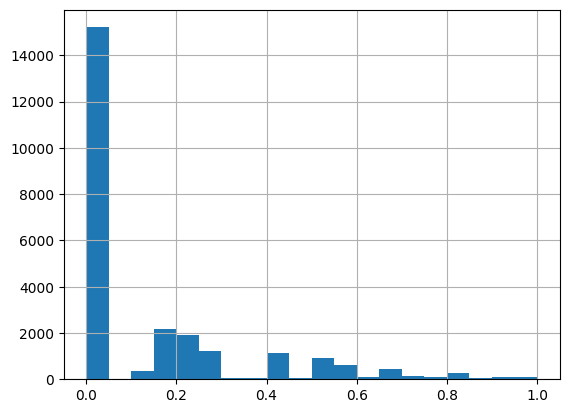

In [5]:
df["toxicity"].hist(bins=20)

We'll create 10 partitions; one with low toxicity levels, one with high toxicity levels, and the other 8 with a random mix of toxicity levels.

In [6]:
def assign_partition(toxicity):
    if toxicity < 0.1:
        return "9_low"
    elif toxicity > 0.9:
        return "9_high"
    else:
        i = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8])
        return f"{i}_medium"

df["partition"] = df["toxicity"].apply(assign_partition)
df.head()

,Unnamed: 0,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,...,disability_any,identity_any,num_identities,more_than_one_identity,na_gender,na_orientation,na_religion,na_race,na_disability,partition
0,315698,5041802,"Thank you Stephanie, great post. You should be...",train,2017-03-23 02:09:07.887924+00,55,NaN,320734,approved,0,...,0,0,0.0,False,1,1,1,1,1,9_low
1,205291,5924876,"Poor, poor us! We're so abused! Give it a brea...",train,2017-09-09 14:08:31.131728+00,54,5923381.0,375645,rejected,0,...,0,1,1.0,False,0,1,1,1,1,5_medium
2,98697,5926727,"Yeah, as we've gotten so used to with the Rock...",train,2017-09-09 20:35:55.150162+00,102,5924578.0,375714,approved,0,...,0,0,0.0,False,1,1,1,1,1,9_low
3,42002,5785459,"If your actions thereby assist Sears' failure,...",test,2017-08-17 04:15:42.186750+00,54,5785299.0,367422,approved,0,...,0,0,0.0,False,1,1,1,1,1,9_low
4,385519,5240478,"It is indeed a balancing act, but by supportin...",train,2017-05-10 22:34:47.727569+00,53,5238832.0,333501,approved,0,...,0,1,2.0,True,0,1,0,1,1,1_medium


## Create Embeddings

For the `comment_text` column, we create embeddings using the huggingface `sentence-transformers` library.

In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
comments = df["comment_text"].tolist()
embeddings = model.encode(comments, show_progress_bar=True)

Batches: 100%|██████████| 782/782 [03:04<00:00,  4.25it/s]


In [8]:
df["comment_embedding"] = [e for e in embeddings]

## Create Partition Summaries

We use the `summarize` function to create partition summaries for each partition. We use the `comment_text` column as the embedding key, and the `comment_embedding` column as embedding value. We also pass in other columns that we want to compute statistics for.

In [9]:
columns = [
    "rating",
    "toxicity",
    "funny",
    "wow",
    "sad",
    "likes",
    "disagree",
    "severe_toxicity",
    "obscene",
    "sexual_explicit",
    "identity_attack",
    "insult",
    "threat",
    "male",
    "female",
    "transgender",
    "other_gender",
    "heterosexual",
    "homosexual_gay_or_lesbian",
    "bisexual",
    "other_sexual_orientation",
    "christian",
    "jewish",
    "muslim",
    "hindu",
    "buddhist",
    "atheist",
    "other_religion",
    "black",
    "white",
    "asian",
    "latino",
    "other_race_or_ethnicity",
    "physical_disability",
    "intellectual_or_learning_disability",
    "psychiatric_or_mental_illness",
    "other_disability",
    "identity_annotator_count",
    "toxicity_annotator_count",
    "LGBTQ",
    "other_religions",
    "asian_latino_etc",
    "disability_any",
    "identity_any",
    "num_identities",
    "more_than_one_identity",
    "na_gender",
    "na_orientation",
    "na_religion",
    "na_race",
    "na_disability",
]
partition_key = "partition"
embedding_key = "comment_text"
embedding_value = "comment_embedding"

In [10]:
summaries = summarize(df, columns, partition_key=partition_key, embedding_column_map={embedding_key: embedding_value})
print(f"Computed summaries for {len(summaries)} partitions.")

Computed summaries for 10 partitions.


We can print out the summary of the first partition:

In [11]:
print(summaries[0])

Regular summary:
   partition                               column  coverage       mean  num_unique_values  occurrence_ratio   p50        p95
0   1_medium                                LGBTQ       1.0   0.058120                2.0          0.941880   0.0   1.000000
1   1_medium                                asian       1.0   0.016524                NaN               NaN   0.0   0.000000
2   1_medium                     asian_latino_etc       1.0   0.017949                2.0          0.982051   0.0   0.000000
3   1_medium                              atheist       1.0   0.006909                NaN               NaN   0.0   0.000000
4   1_medium                             bisexual       1.0   0.002165                NaN               NaN   0.0   0.000000
5   1_medium                                black       1.0   0.070698                NaN               NaN   0.0   0.833333
6   1_medium                             buddhist       1.0   0.003419                NaN               NaN 

## Compute Drift

For each partition after the first 5 partitions, we compute the drift between the partition and historical partitions.

In [12]:
partition_names = [s.partition for s in summaries]

In [13]:
drifted_partitions = {}

for i in range(len(summaries)-2, len(summaries)):
    print(f"Checking partition {partition_names[i]}...")
    drift_results = detect_drift(summaries[i], summaries[:i])    
    if drift_results.is_drifted:
        print(f"Drift detected in partition {partition_names[i]}!")
        drifted_partitions[partition_names[i]] = drift_results

Checking partition 9_high...
Drift detected in partition 9_high!
Checking partition 9_low...
Drift detected in partition 9_low!


## Inspect Drift Results

For the high and low toxicity partitions, we can print out the top drifted columns and drift score.

Looks like the top drifted columns for high toxicity imply that there more insults (z score is higher than 0). It also looks like there are more sexual explicit annotations (z score is higher than 0).

The top drifted columns for the low toxicity partition show that there were fewer Muslim-annotated records (z score < 0).

In [14]:
def get_summary(partition_name):
    for summary in summaries:
        if summary.partition == partition_name:
            return summary
    return None


partition_name = list(drifted_partitions.keys())[0]
print(partition_name)
drift_results_high = drifted_partitions[partition_name]
print(drift_results_high)

9_high
Drift score: 5.7985 (100.00% percentile)
Top drifted columns:
                              statistic   z-score  cluster   
column                                                       
toxicity_annotator_count            p50 -2.666667      1.0  \
insult                              p50  2.666667      3.0   
identity_any                        p50 -2.666667      3.0   
LGBTQ                               p95 -2.666667      0.0   
num_identities                      p50 -2.666667      0.0   
psychiatric_or_mental_illness       p95  2.666667      0.0   
toxicity                            p50  2.666667      0.0   
white                               p95 -2.666667      0.0   
severe_toxicity                     p95  2.666666      0.0   
sexual_explicit                     p95  2.666666      0.0   

                               abs(z-score-cluster)  
column                                               
toxicity_annotator_count                   0.533333  
insult                  

In [15]:
partition_name = list(drifted_partitions.keys())[1]
print(partition_name)
drift_results_low = drifted_partitions[partition_name]
print(drift_results_low)

9_low
Drift score: 6.6179 (100.00% percentile)
Top drifted columns:
                                  statistic   z-score  cluster   
column                                                           
muslim                                  p95 -2.846050      1.0  \
white                                   p95 -2.757435      0.0   
toxicity_annotator_count   occurrence_ratio  2.741892      0.0   
toxicity                                p95 -2.706182      2.0   
sexual_explicit                        mean -2.675625      5.0   
identity_attack                        mean -2.667935      4.0   
funny                     num_unique_values  2.667320      0.0   
insult                                  p95 -2.627668      0.0   
LGBTQ                      occurrence_ratio  2.508447      3.0   
sad                       num_unique_values  2.449490      0.0   

                          abs(z-score-cluster)  
column                                          
muslim                                2.8

In [16]:
print(f"There were {len(drift_results_high.clustering)} clusters of columns identified in the high toxicity partition and {len(drift_results_low.clustering)} clusters of columns in the low toxicity partition.")

There were 6 clusters of columns identified in the high toxicity partition and 8 clusters of columns in the low toxicity partition.


### Look at Drifted Embeddings for High Toxicity Partition

In the drifted partition, we can identify the cluster of embeddings that diverged most from its values in historical partitions.

`drifted_examples` represents the examples in the drifted partition. `corresponding_examples` represents the examples in the historical partitions.

In [17]:
result = drift_results_high.drifted_examples("comment_text")
drifted_examples = result["drifted_examples"]
corresponding_examples = result["corresponding_examples"]

In [18]:
drifted_examples[embedding_key].to_list()

["Shameful idiotic response from someone who has no idea about justice. It's people like you who think justice is something to ridicule.",
 'This bible thumping imbecile is a disgrace to Indiana my home state.  He signed a so-called "Religious Freedom" bill that almost killed Indianapolis\' large convention business until it was repealed.  Senator Corker can add one more to the "White House Adult Daycare" roster.',
 'Things change.  Get a bigger helmet.  None of your sad sick leftist procedures will do anything about it.',
 'Yes, this is the part the biggest fools in the country continue to overlook, even the stories in this very publication that spell out the facts to them go whistling right past their heads because- "Native", so automatically inferior. No effort to read the real history or understand the processes that turned complex, industrious societies into wards of the state fighting for their independence. They wouldn\'t even recognize a passage in the very Indian Act that gran

In [19]:
corresponding_examples[embedding_key].to_list()

["It'll be curious to hear what the evangelical Christian community has to say on Moore’s actions. I’m not sure what their position on child molestation is, but I hope they are against it.",
 'We agree that Christ is God yes? Then why would he have corrected the mosaic practice of divorce, and making marriage a bond of two beings becoming one flesh joined by God. Who has the proper authority to rip such a being apart? God or the Pope?',
 'Our diocese has a revolving door of bishops . Every time another one shows up he hires a firm which specializes in fund raisers for Catholic Churches .  There is no lack of shiny , thick and colorful brochures .  Why it is thought we are prepared to donate  e.g. $225,000. over five years ...beyond me .  But they will accept less if that\'s what you can do .  However ,\nI will not join in these capital campaigns unless and until something is done to give us a prayerful Eucharistic liturgy  . \nAs the source and summit of a prayerful life of worship why

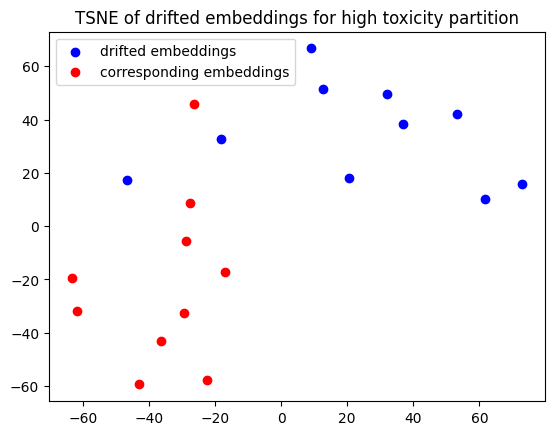

In [20]:
# T-sne for examples

drifted_embeddings = np.vstack(drifted_examples[embedding_value].values)
correspending_embeddings = np.vstack(corresponding_examples[embedding_value].values)

# Concatenate the two arrays vertically
X = np.vstack([drifted_embeddings, correspending_embeddings])

# Compute t-SNE on the concatenated data
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X)

# Separate the t-SNE results for X1 and X2
X1_tsne = X_tsne[:10, :]
X2_tsne = X_tsne[10:, :]

# Plot the results
fig, ax = plt.subplots()
ax.scatter(X1_tsne[:, 0], X1_tsne[:, 1], color='blue', label='drifted embeddings')
ax.scatter(X2_tsne[:, 0], X2_tsne[:, 1], color='red', label='corresponding embeddings')
ax.legend()
plt.title("TSNE of drifted embeddings for high toxicity partition")
plt.show()

We can do the same thing from the low toxicity partition.

In [21]:
result = drift_results_low.drifted_examples("comment_text")
drifted_examples = result["drifted_examples"]
corresponding_examples = result["corresponding_examples"]

In [22]:
drifted_examples[embedding_key].to_list()

['Use to be, the rubbish men would come by twice a week and pick up all the rubbish, two guys in the back of the truck and the driver.  Was hard work, injuries and paying the 3 employees when cost plenty money.  For save money, the city when go with the one arm bandit and pick-up the city issued big rubbish can twice a week. They when then change to once a week for rubbish and once a week for the recycle stuff. The city was supposed to get money for the recycle stuff, but something when happen and the city when lose money again.  Anyway, the point is, rubbish pick-up now only take one guy who no get injured as much. The cost of trash service should have gone down not up.',
 "The US never apologized for Slavery let alone paid reparation to descendants of black slaves. Contrast that to Germany which not only fully owned up to its dark history but made tangible amends by paying restitution and maturely teaching its people about the dark horrors of WW2. As a result, you would not see in Ge

In [23]:
corresponding_examples[embedding_key].to_list()

['Take and eat, for this is my body. (Bad proof texting on your part).  We have faith in the witness of the apostles for the Resurrection. That witness means more than all the Sacraments. \n\nI believe what the Church teaches. How it operates is the issue. The fact that you are getting personal means you have no counter-argument. You cannot even see the paradigm you operate in.\n\nI can see why magicism is the rule of the day in the hiearchy and among trads. In a magical paradigm, women can not be ordained for questions of validity (good magic). If you have a faith paradigm, there is no reason at all not to do so. I used to think it was just sexism, but I am changing my mind. That is also the reason behind Continence, which has poisoned the entire well of Catholic sexual theology.',
 "We all know your views on gay men.  Though I have to wonder, how does the life choices(which it's not a choice) of gay men effect you.  Are you at risk for HIV infection from either a gay man, or injectio

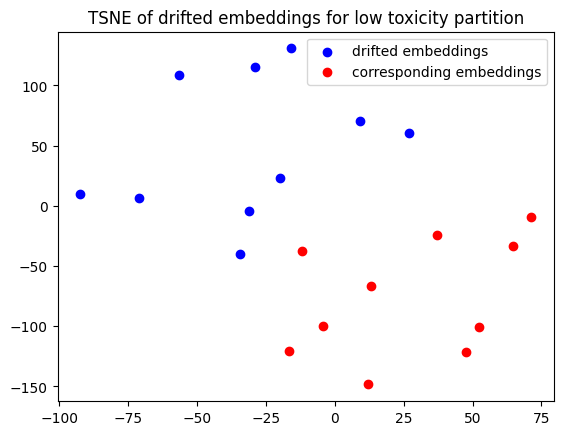

In [24]:
# T-sne for examples

drifted_embeddings = np.vstack(drifted_examples[embedding_value].values)
correspending_embeddings = np.vstack(corresponding_examples[embedding_value].values)

# Concatenate the two arrays vertically
X = np.vstack([drifted_embeddings, correspending_embeddings])

# Compute t-SNE on the concatenated data
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X)

# Separate the t-SNE results for X1 and X2
X1_tsne = X_tsne[:10, :]
X2_tsne = X_tsne[10:, :]

# Plot the results
fig, ax = plt.subplots()
ax.scatter(X1_tsne[:, 0], X1_tsne[:, 1], color='blue', label='drifted embeddings')
ax.scatter(X2_tsne[:, 0], X2_tsne[:, 1], color='red', label='corresponding embeddings')
ax.legend()
plt.title("TSNE of drifted embeddings for low toxicity partition")
plt.show()